A lot of names muust be changed in this notebook, it's based on the previous attempt and at the moment
only the C++ code has been added here.

In [2]:
from pyprotolinc._actuarial import BaseAssumptions


In [4]:
import pyprotolinc._actuarial as actuarial
from pyprotolinc._actuarial import Portfolio

In [6]:
Portfolio()
actuarial.portfolio_valuation()

TypeError: __init__() takes exactly 2 positional arguments (0 given)

# Whole of Life

In [1]:
from datetime import datetime
import os

import numpy as np
import pandas as pd

from insurance_valuation.actuarial import BaseAssumptions
import insurance_valuation.actuarial as actuarial
from insurance_valuation.mortality import weibull_mortality_rates
from insurance_valuation.data import ValuationPortfolioFile
from insurance_valuation.valuation_helpers import age_at_date
from insurance_valuation.actuarial import Portfolio

### Parameters

In [2]:
# parameters relating to the valuation run itself
valuation_date = datetime(year=2019, month=9, day=15)

### Load Portfolio

In [3]:
#portfolio_file = os.path.join("portfolio_data", "portfolio1.xlsx")
portfolio_file = os.path.join("portfolio_data", "tod_all_combined_aggr_grouped_20_pc_smokers.xlsx")
portfolio_inforce_date = datetime(year=2017, month=12, day=31)
pf = ValuationPortfolioFile(portfolio_file, portfolio_inforce_date)

df_portfolio = pf.prepare_for_calc()
df_portfolio.head()

,CESSIONID,PRODUCTTYPE,STATUS,VOLUME,VOLUMETYPE,GENDER,REINPREMPAYPERIOD,REINCOVERAGEPERIOD,FIRSTINSCOVERAGEPERIOD,FIRSTINSPREMPAYPERIOD,MAXTOAGEBENEFITPERIOD,SMOKERSTATUS,OCCUPATIONCLASS,COVERAGE_YEARS,DATE_OF_BIRTH_LONG,PORTFOLIO_DATE_LONG,ISSUE_DATE_LONG,DISABLEMENT_DATE_LONG
0,1000468,EW,A,101783,0,F,36,36,36,36,0,N,##,36,19640101,20171231,19900701,0
1,1000499,EW,A,4191,0,F,29,29,29,29,0,N,##,29,19560101,20171231,19920701,0
2,1000548,EW,A,24126,0,F,36,36,36,36,0,N,##,36,19710101,20171231,19950701,0
3,1000565,EW,A,13147,0,F,27,27,27,27,0,S,##,27,19720101,20171231,19950701,0
4,1000566,EW,A,227250,0,F,36,36,36,36,0,N,##,36,19740101,20171231,19960701,0


In [4]:
df_portfolio.VOLUME.sum()

787816944316

In [5]:
#df_portfolio.info()

### Policy

In [6]:
# use one one record only!!!!!!!!!!!!!!!!!!
val_pf = Portfolio(df_portfolio[:], pf.portfolio_name)

record = df_portfolio.iloc[0]
sum_insured = record.VOLUME
#attained_age, additional_days = age_at_date(birthday, proj_start_date)
#attained_age, additional_days 
#print(record)


val_pf.get(0)[3]

101783.0

### Assumptions

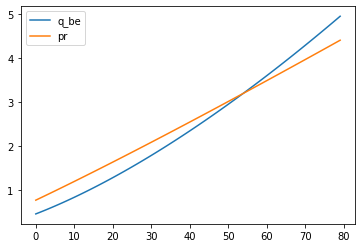

In [8]:
# base_mort.get_for_age(110)
%matplotlib inline
pd.DataFrame({"q_be": weibull_mortality_rates(k=0.5/100000, n=1.5)[20:100],
              "pr": 1.4*weibull_mortality_rates(k=2/100000, n=1.1)[20:100]}).plot();

In [9]:
# create base assumptions
q_be = weibull_mortality_rates(k=0.5/100000, n=1.5)
l_be = 0.05 * 1000 * np.ones(120)
l_locgaap = np.zeros(120)

# 20%  loading for premium assumptions
q_locgaap = 1.2 * q_be
q_locgaap[-1] = q_be[-1]

premium_assumptions = 1.2*weibull_mortality_rates(k=2/100000, n=1.1)
premium_assumptions[-1] = q_locgaap[-1]

base_mort = BaseAssumptions(0, q_be, q_locgaap, premium_assumptions, l_be, l_locgaap)

In [12]:
len(val_pf)

8628

### Valuation

In [11]:
from insurance_valuation.actuarial import portfolio_valuation
df_res = portfolio_valuation(None, base_mort, val_pf)#[:].groupby("YEAR").sum()[:20]
%timeit df_res = portfolio_valuation(None, base_mort, val_pf)#[:].groupby("YEAR").sum()[:20]

#df_res.to_csv("out2.csv")
df_res#[df_res["YEAR"] >= 2028]

29.3 ms ± 375 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


,YEAR,MONTH,Premium,DeathClaims,LG_Reserve,SumInsured,MovementActDeath,MovementActLapse,AverageAge,qx_yrly_be,lx_yrly_be,pr_yrly_be,qx_yrly_lg,lx_yrly_lg,pr_yrly_lg
1,2018,1,0.0,-1.165826e+08,2.643299e+09,7.877233e+11,1.165826e+08,3.281770e+06,50.087633,0.001774,0.00005,0.001764,0.002129,0.0,0.001764
2,2018,2,0.0,-1.200322e+08,2.514210e+09,7.876034e+11,1.200322e+08,3.281256e+06,50.170540,0.001827,0.00005,0.001803,0.002193,0.0,0.001803
3,2018,3,0.0,-1.200119e+08,2.380453e+09,7.874801e+11,1.200119e+08,3.280742e+06,50.253444,0.001827,0.00005,0.001803,0.002193,0.0,0.001803
4,2018,4,0.0,-1.199916e+08,2.246171e+09,7.873568e+11,1.199916e+08,3.280228e+06,50.336347,0.001827,0.00005,0.001803,0.002193,0.0,0.001803
5,2018,5,0.0,-1.199713e+08,2.111362e+09,7.872335e+11,1.199713e+08,3.279715e+06,50.419251,0.001827,0.00005,0.001803,0.002193,0.0,0.001803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436,2137,8,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1437,2137,9,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1438,2137,10,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1439,2137,11,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#from insurance_valuation.actuarial import portfolio_valuation
#k=2
#for k in range(df_portfolio.shape[0]):
#    val_pf = Portfolio(df_portfolio[k:k+1], pf.portfolio_name)
#    df_res = portfolio_valuation(None, base_mort, val_pf)#[:].groupby("YEAR").sum()[:20]
#    sar = val_pf.get(0)[3]
#    delta = df_res[:1].SumInsured.values[0] - sar
#    if abs(delta) > 1:
#        print(k, delta, df_res[:1].SumInsured.values[0], sar)

### Performance Check

Create a longer portfolio.

In [13]:
df_portfolio_long = pd.concat([pf.df_portfolio[:]]*1000, ignore_index=True)
#df_portfolio_long = pd.concat([df_portfolio_long]*1000, ignore_index=True)
df_portfolio_long.shape

(8628000, 21)

In [12]:
#portfolio_inforce_date.year*10000 + portfolio_inforce_date.month * 100 + portfolio_inforce_date.day
#df_portfolio_long.ISSUE_DATE.dt.year * 10000 + df_portfolio_long.ISSUE_DATE.dt.month *100 + df_portfolio_long.ISSUE_DATE.dt.day 

In [14]:
# care!
pf.df_portfolio = df_portfolio_long
pf.is_prepared = False
df_prep_long = pf.prepare_for_calc()
#val_pf_long = Portfolio(df_prep_long)
#len(val_pf_long)
df_portfolio_long.head()

,CESSIONID,PRODUCTTYPE,STATUS,VOLUME,VOLUMETYPE,GENDER,ISSUEYEAR,ISSUEMONTH,ISSUEDAY,ISSUEAGE,...,DISABLEMENTMONTH,DISABLEMENTDAY,REINPREMPAYPERIOD,REINCOVERAGEPERIOD,FIRSTINSCOVERAGEPERIOD,FIRSTINSPREMPAYPERIOD,MAXTOAGEBENEFITPERIOD,SMOKERSTATUS,OCCUPATIONCLASS,COVERAGE_YEARS
0,1000468,EW,A,101783.0,0,F,1990,7,1,26,...,0,0,36,36,36,36,0,N,##,36
1,1000499,EW,A,4191.0,0,F,1992,7,1,36,...,0,0,29,29,29,29,0,N,##,29
2,1000548,EW,A,24126.0,0,F,1995,7,1,24,...,0,0,36,36,36,36,0,N,##,36
3,1000565,EW,A,13147.0,0,F,1995,7,1,23,...,0,0,27,27,27,27,0,S,##,27
4,1000566,EW,A,227250.0,0,F,1996,7,1,22,...,0,0,36,36,36,36,0,N,##,36


In [15]:
#df_portfolio["COVERAGE_YEARS"] = df_portfolio["COVERAGE_YEARS"].astype('int32')
#df_prep_long["COVERAGE_YEARS"] = df_prep_long["COVERAGE_YEARS"].astype('int32')

In [16]:
val_pf_long = Portfolio(df_prep_long, "TEST")
len(val_pf_long)

8628000

In [17]:
%timeit portfolio_valuation(None, base_mort, val_pf_long)

#res = portfolio_valuation(None, base_mort, val_pf_long)#[:, :2]
#res[:10, :2]

13.3 s ± 604 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
res = portfolio_valuation(None, base_mort, val_pf_long)#[:, :2]
res.groupby("YEAR").sum()[:20]

,MONTH,Premium,DeathClaims,LG_Reserve,SumInsured,MovementActDeath,MovementActLapse,AverageAge,qx_yrly_be,lx_yrly_be,pr_yrly_be,qx_yrly_lg,lx_yrly_lg,pr_yrly_lg
YEAR,,,,,,,,,,,,,,
2018,78,1.418779e+12,-1.435743e+12,3.003762e+13,9.444277e+15,1.435743e+12,3.934607e+10,606.515086,0.021871,0.0006,0.021596,0.026246,0.0,0.021596
2019,78,1.370451e+12,-1.432031e+12,2.750783e+13,9.236564e+15,1.432031e+12,3.848060e+10,614.835106,0.022302,0.0006,0.021919,0.026762,0.0,0.021919
2020,78,1.240118e+12,-1.342688e+12,2.446980e+13,8.593898e+15,1.342688e+12,3.580314e+10,618.190602,0.022466,0.0006,0.022048,0.026960,0.0,0.022048
2021,78,1.096959e+12,-1.201930e+12,2.139733e+13,7.687640e+15,1.201930e+12,3.202756e+10,618.579448,0.022475,0.0006,0.022061,0.026970,0.0,0.022061
2022,78,8.925795e+11,-1.020293e+12,1.835245e+13,6.594978e+15,1.020293e+12,2.747545e+10,614.009612,0.022211,0.0006,0.021880,0.026653,0.0,0.021880
2023,78,7.637476e+11,-8.459098e+11,1.591711e+13,5.543430e+15,8.459098e+11,2.309463e+10,609.077934,0.021930,0.0006,0.021685,0.026316,0.0,0.021685
2024,78,6.780443e+11,-7.353946e+11,1.406162e+13,4.834680e+15,7.353946e+11,2.014190e+10,608.152718,0.021868,0.0006,0.021647,0.026242,0.0,0.021647
2025,78,5.903538e+11,-6.464422e+11,1.244170e+13,4.258302e+15,6.464422e+11,1.774064e+10,607.501205,0.021820,0.0006,0.021620,0.026184,0.0,0.021620
2026,78,5.334764e+11,-5.723320e+11,1.109085e+13,3.773255e+15,5.723320e+11,1.571987e+10,607.608578,0.021811,0.0006,0.021622,0.026173,0.0,0.021622


In [19]:
res.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1440 entries, 1 to 1440
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   YEAR              1440 non-null   int32  
 1   MONTH             1440 non-null   int32  
 2   Premium           1440 non-null   float64
 3   DeathClaims       1440 non-null   float64
 4   LG_Reserve        1440 non-null   float64
 5   SumInsured        1440 non-null   float64
 6   MovementActDeath  1440 non-null   float64
 7   MovementActLapse  1440 non-null   float64
 8   AverageAge        774 non-null    float64
 9   qx_yrly_be        774 non-null    float64
 10  lx_yrly_be        774 non-null    float64
 11  pr_yrly_be        774 non-null    float64
 12  qx_yrly_lg        774 non-null    float64
 13  lx_yrly_lg        774 non-null    float64
 14  pr_yrly_lg        774 non-null    float64
dtypes: float64(13), int32(2)
memory usage: 168.8 KB


### Correctness Check

In [ ]:
def cf_whole_of_life_py(sum_insured, qx1000, lx1000, output):
    qx = qx1000 / 1000.0
    lx = lx1000 / 1000.0
    px = (1 - qx)*(1 - lx)
    px_cum = np.ones(px.shape[0])
    px_cum[1:] = px[:-1]
    px_cum.cumprod()
    payment_probabilities = qx * px_cum.cumprod()
    # print(qx[:5])
    # print(px_cum[:5])
    output[0:payment_probabilities.shape[0]] = sum_insured * payment_probabilities

py_exp_cf = np.zeros((120, 2))
cf_whole_of_life_py(sum_insured, m[:, 0], l[:, 0], py_exp_cf[:, 1])
py_exp_cf[:, 1] *= -1
cf_whole_of_life_py(sum_insured, m[:, 1], l[:, 0], py_exp_cf[:, 0])

py_exp_cf[:]

In [ ]:
expected_claims = np.zeros((120, 2))
%timeit cf_whole_of_life_py(sum_insured,  m[:, 0], l[:, 0], expected_claims[:, 0])
expected_claims[:15,:]

In [ ]:
%load_ext Cython
assert False

In [ ]:
%%cython
# distutils: language = c++

from insurance_valuation.actuarial cimport BaseAssumptions
from insurance_valuation.actuarial cimport Portfolio

def portfolio_valuation(valuation_date, BaseAssumptions base_ass, Portfolio pf):
    pass    